# Qualitative Directed Search

## Part 1: Motivating Tiers

James Yu, Vancouver School of Economics

20 December 2023

In [1]:
using Pkg
Pkg.activate("../") # use the Mapinator estimation manifest
Pkg.instantiate()

  Activating project at `C:\Users\jbrig\Documents\econ622\qualitative_directed_search`


### Introduction

Labour markets are central to the evolution of individuals' career pathways. For example, different jobs can lead to different experiences or knowledge, which in turn impact future opportunities and career choices. Understanding these markets with structural models provides insight into the welfare of market participants; these models can suggest ways in which welfare could be improved in the future.

In traditional theoretical literature, there are many popular models of labour markets where workers match with firms (Wright et al., 2019; Chade et al., 2016). These include the random matching model, where workers and firms match randomly; as well as the more complex directed search model, where the applications or offers that drive matches are targeted. More comprehensive models, such as directed search, allow for richer structure and thus stronger model predictions.

Taking directed search as a baseline, Peters & Yu (2023, in progress) models the entry-level academic job market for graduates of economics Ph.D. programs. They expand on the baseline model by adding frictions in the acquisition of information regarding job applicants, introducing the idea that employers may only be able to rank clusters of similar applicants rather than every individual applicant. This idea relies on some key informational assumptions, including that the number of clusters along with the market value of graduates in each cluster are exogenous and commonly known to all market participants.

These exogenous graduate values represent a composition of several observable and unobservable job market factors, including technical skills and research potential. With the increasing availability of "big data", it is becoming feasible to extend directed search to study the impact of these high-dimensional factors on market outcomes. My project aims to gradually study this extension.

### The Model (515)

I adapt the expanded directed search model from Peters & Yu (2023, in progress), focusing on motivating the graduate clusters and their values. In their model, graduates apply to every available position on the market. Employers, composed of universities and organizations, must allocate job offers associated with positions to graduates; graduates then accept the highest received offer.

The model assumes that every employer in the market is using the same exogenous graduate cluster values without any coordination; this suggests that the values are stable, and using a different cluster composition would not be optimal for any employer. These clusters are assumed to be the result of information acquisition costs; if there were no costs, then employers would be able to recover the true values associated with each graduate. Since values can be ordered on the real line, I can then define clusters by placing scalar cutoffs around the true values. This suggests that there exists a sequence of cutoffs that produces a stable set of clusters and cluster values.

Originally, I posited that these sequences would be equilibrium choices used by every employer. As a result, no employer would have an incentive to use a different cutoff sequence and therefore a different cluster composition, providing a model of value stability. However, for employers to use and create these sequences, they must already know the true graduate values, which are not necessarily known to employers without processing full applications. This defeats the purpose of clusters, which exist because of the idea that employers may not be able to conduct full application processing. I must therefore use a different approach than my original idea.

To gain an understanding of how cluster stability may be motivated under information acquisition cost, I create the following exercise.

### Estimating Payoff Differences (622)

Earlier this Fall, I wrote a placement outcome simulator [(now uploaded here for reference)](https://github.com/jbrightuniverse/mapinator/blob/master/estimation/simulate_matching.ipynb) based on earlier [code for Peters & Yu (2023)](https://github.com/jbrightuniverse/mapinator/tree/master/estimation) to conduct some initial analysis for this project's long-term goals. I did not compute any substantial results with it at the time.

In this exercise, I reconfigure that code to compute the expected payoffs of this game under simulated markets. I list my changelogs in the code.

If a particular set of clusters and their values is stable, then deviating from this set of clusters should not be optimal for the market as a whole. My reconfigured simulator allows me to compute the expected payoffs, among departments in each tier, associated with a particular choice of clusters; if the choice is stable, deviating from the choice should not be profitable. The simulator would allow me to search for conditions under which stability holds, if such conditions exist. I leave interpretation of the simulator's results for future stages of this project.

Below I provide the code associated with the simulator. For the parts of the code adapted from previous files, I provide additional documentation.

In [2]:
"""
    adapted from the placement outcomes simulator simulate_matching.ipynb 
        and the model estimator estimate_model_two_rounds.jl
    changelog:
        - not including the market second round code
        - changed get_outcome_distribution to get_expected_outcomes
            - adjusted comments
            - adjusted code to return expectations instead of distribution parameters
            - expectation code is adapted from estimate_model_two_rounds.jl
        - added extra annotations
        - dropped unused function pi
"""

using Distributions, Integrals, Random, Roots, StatsPlots

# these functions are implementations of expressions from the paper
# they are used to compute hiring probabilities
# the hiring probabilities are used to compute expected placement outcomes

# CDF of employer wage where employer type is unknown
function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

# PDF of the above
function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

# helper function for hiring probability
function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

# helper function for hiring probability
function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

# PDF of employer wage distribution with known type
function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

# hiring probability
function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    return sum([(α[t]/sum(α[1:s])) * solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], 
                F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) * fi(x, μ[i], σ[i]), 
                    x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

# helper function for equilibrium wage cutoffs
function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

"""
computes expected placement outcomes according to the following specification:

    v_rel: vector of relative values v2/v1, v3/v2, v4/v3, ...
    α: vector of graduate-department ratio constants α_i
    μ: vector of μ parameters for the offer distributions
    σ: vector of σ parameters for the offer distributions
    ρ: vector of ratios for number of departments per tier
    k: number of graduating tiers
    K: number of hiring tiers
    M: number of placement outcomes

"""
function get_expected_outcomes(v_rel, α, μ, σ, ρ, k, K, M)
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    normalizer = 0.0
    q_it = zeros(K, k)
    for i in 1:K
        for t in 1:k
            prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
            q_it[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    expectation = zeros(K, k)
    for i in 1:K
        for t in 1:k
            expectation[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        end
    end

    return expectation
end

get_expected_outcomes

To compute the expected payoff for employers of a given type, I introduce this additional function:

In [3]:
function payoffs(expectation, v_base)
    # matrix multiplication technique for aggregating values suggested by Mike Peters
    return expectation * v_base
end

payoffs (generic function with 1 method)

In [4]:
# unit test for payoffs()

test_matrix = [0.1 0; 
                0 0.1]
test_vector = [1, 0.3]

# ensure that the matmul payoffs() works with vectors 
@assert payoffs(test_matrix, test_vector) == [0.1; 0.03]
@assert payoffs(test_matrix, test_vector) == [0.1, 0.03]

In [5]:
"""
    adapted from the placement outcomes simulator simulate_matching.ipynb
    changelog:
        -parameter changes
        -additional annotations
        -adjusted code to be a function
        -adjusted code to compute expected payoffs rather than simulate placements
"""
function get_expected_payoffs(v_base)
    Random.seed!(0) # for reproducibility

    # the number of applicant (graduate) and employer (department) tiers
    num_graduates = length(v_base)
    num_departments = num_graduates   

    # value ratios
    v_rel = zeros(num_graduates-1)
    for i in 1:num_graduates-1
        v_rel[i] = v_base[i+1] / v_base[i]
    end

    # additional model parameters, described earlier
    α = ones(num_graduates) / num_graduates # the same number of applicants in each tier
    μ = range(0.25, 0.75, num_departments)
    σ = 0.1 * ones(num_departments)
    ρ = ones(num_departments) / num_departments # the same number of employers in each tier
    M = 10000
    
    expected_outcomes = get_expected_outcomes(v_rel, α, μ, σ, ρ, num_graduates, num_departments, M)
    payoff = payoffs(expected_outcomes, v_base)
    return expected_outcomes, payoff
end

get_expected_payoffs

In [6]:
function display_results(res)
    # simple output display function
    expected_outcomes, payoff = res
    println("Expected outcomes:")
    display(expected_outcomes)
    println()
    println("Total payoffs for each tier:")
    display(payoff)
    println()
    println("Total market payoff:")
    display(sum(payoff))
end

display_results (generic function with 1 method)

Here I provide some brief demonstrations of the simulator's functionality:

In [7]:
display_results(get_expected_payoffs([1, 0.6, 0.4, 0.3])) # four tiers, ordered from highest to lowest

Expected outcomes:


4×4 Matrix{Float64}:
  237.582   395.969  593.633  770.269
  343.408   570.77   798.938  635.944
  742.786  1031.96   697.503  123.861
 2076.91    868.253  109.696    2.51878


Total payoffs for each tier:


4-element Vector{Float64}:
  943.6974857119544
 1196.2284162630629
 1678.1186311294582
 2642.499421711155


Total market payoff:


6460.54395481563

In [8]:
display_results(get_expected_payoffs([1, 0.6, 0.4])) # consolidate to three tiers

Expected outcomes:


3×3 Matrix{Float64}:
  505.619   842.696  1258.85
  864.955  1400.63   1064.27
 2870.56   1159.84     32.5832


Total payoffs for each tier:


3-element Vector{Float64}:
 1514.774997696668
 2131.0401894019665
 3579.500934823829


Total market payoff:


7225.316121922464

In [9]:
display_results(get_expected_payoffs([1, 0.6, 0.3])) # reduce value of one of the tiers

Expected outcomes:


3×3 Matrix{Float64}:
  496.731   827.884  1457.98
 1037.71   1687.04    295.654
 2983.3    1213.22      0.482551


Total payoffs for each tier:


3-element Vector{Float64}:
 1430.8565517480433
 2138.631540448798
 3711.3726656324084


Total market payoff:


7280.86075782925

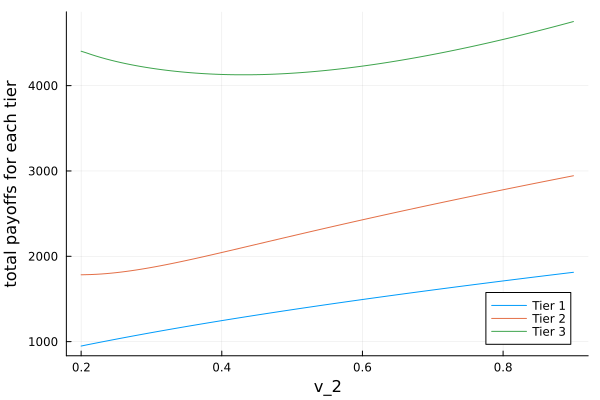

In [10]:
# plot the changes in payoff as a tier's value increases
grid = range(0.2, 0.9, 100)
payoff_result = [get_expected_payoffs([1, g, 0.1])[2] for g in grid]
plot(grid, [payoff[1] for payoff in payoff_result], label = "Tier 1")
plot!(grid, [payoff[2] for payoff in payoff_result], label = "Tier 2")
plot!(grid, [payoff[3] for payoff in payoff_result], label = "Tier 3")
xlabel!("v_2")
ylabel!("total payoffs for each tier")